In [1]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import xtrack as xt

/Users/giadarol/xsuite_packages/xtrack/xtrack/progress_indicator.py:95: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Import MAD-X sequence to Xsuite

In [3]:
# Read MAD-X sequence from file (using cpymad)
from cpymad.madx import Madx
mad = Madx()
mad.option(echo=False)
mad.call('PIMM.seq')
mad.beam()
mad.use('pimms')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.09.00  (64 bit, Darwin)      +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2023.05.05               +
  + Execution date: 2024.02.06 15:49:28      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [4]:
# Import in Xsuite
line = xt.Line.from_madx_sequence(mad.sequence.pimms,
                                  deferred_expressions=True)

Converting sequence "pimms":   0%|          | 0/96 [00:00<?, ?it/s]

## Define reference particle

In [5]:
line.particle_ref = xt.Particles(q0=1, mass0=xt.PROTON_MASS_EV,
                                 kinetic_energy0=200e6) # eV

## Inspect machine layout

In [6]:
# Compute survey
sv = line.survey()

<IPython.core.display.Javascript object>


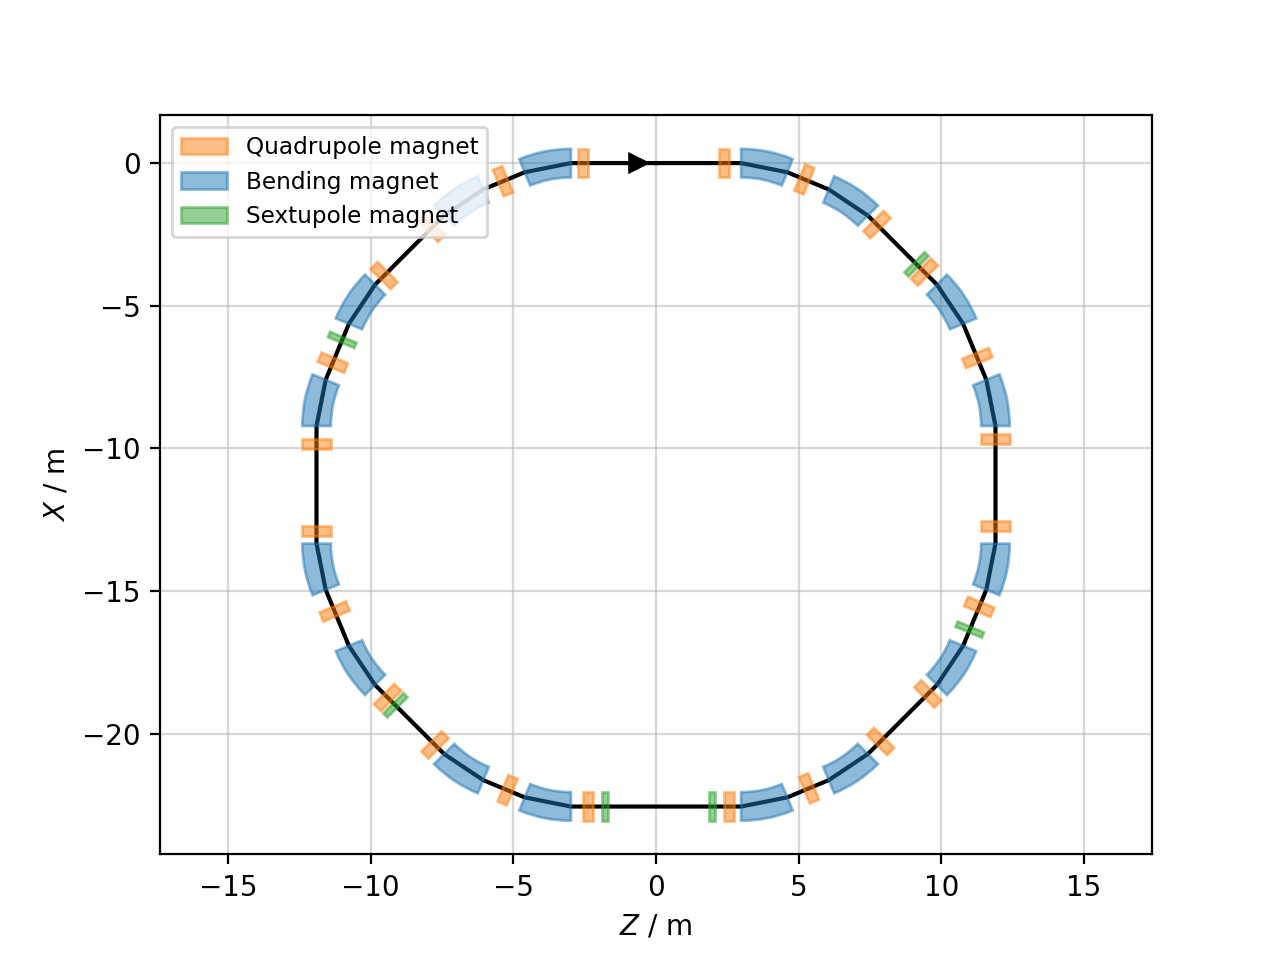

In [7]:
# Plot ring geometry using Xplt (credits P. Niedermayer)
import xplt
xplt.FloorPlot(sv, line)
plt.legend(fontsize='small', loc='upper left')

### Table with machine elements

In [8]:
# To extract a table with all elements in the lattice
tt = line.get_table()

In [9]:
# Inspect first ten elements
tt.rows[:10].show()

name             s element_type isthick compound_name
pimms$start      0 Marker         False              
extr_septum      0 Marker         False              
drift_0          0 Drift           True              
qfa.1_entry 2.2125 Marker         False qfa.1        
qfa.1       2.2125 Quadrupole      True qfa.1        
qfa.1_exit  2.5625 Marker         False qfa.1        
drift_1     2.5625 Drift           True              
mb_entry     2.982 Marker         False mb           
mb_den       2.982 DipoleEdge     False mb           
mb           2.982 Bend            True mb           


In [10]:
# Inspect all quadrupoles
ttquad = tt.rows[tt.element_type=='Quadrupole']
ttquad.show()

name              s element_type isthick compound_name
qfa.1        2.2125 Quadrupole      True qfa.1        
qd.1         5.1175 Quadrupole      True qd.1         
qfa.2        8.1525 Quadrupole      True qfa.2        
qfb.1       10.5025 Quadrupole      True qfb.1        
qd.2        14.0875 Quadrupole      True qd.2         
qfb.2       17.0225 Quadrupole      True qfb.2        
qfb.3       20.0725 Quadrupole      True qfb.3        
qd.3        23.0075 Quadrupole      True qd.3         
qfb.4       26.5925 Quadrupole      True qfb.4        
qfa.3       28.9425 Quadrupole      True qfa.3        
qd.4        31.9775 Quadrupole      True qd.4         
qfa.4       34.8825 Quadrupole      True qfa.4        
qfa.5       39.8325 Quadrupole      True qfa.5        
qd.5        42.7375 Quadrupole      True qd.5         
qfa.6       45.7725 Quadrupole      True qfa.6        
qfb.5       48.1225 Quadrupole      True qfb.5        
qd.6        51.7075 Quadrupole      True qd.6         
qfb.6     

<IPython.core.display.Javascript object>


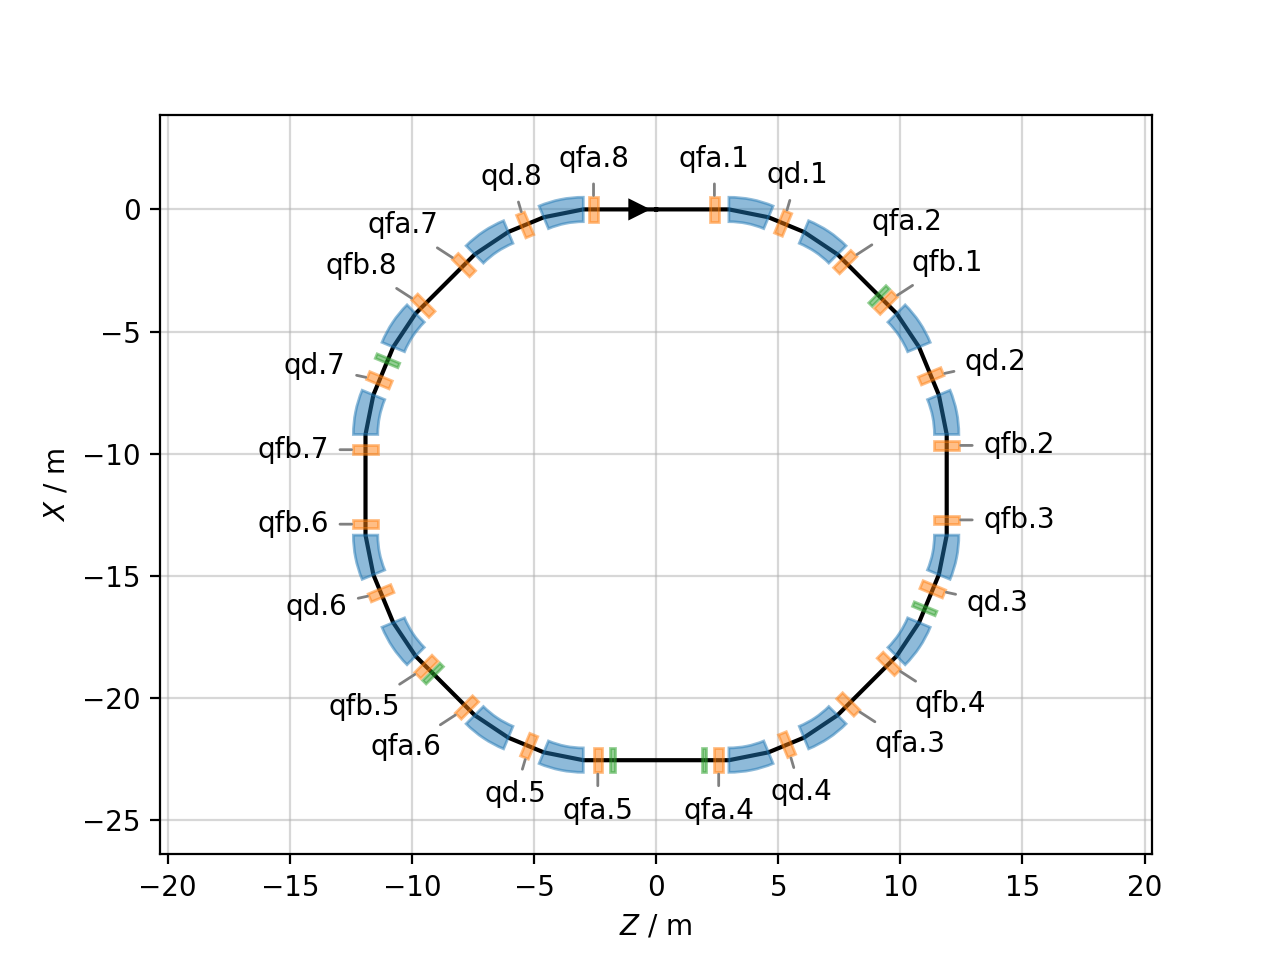

In [11]:
# Label all quadrupoles in survey plot to identify three quadrupole families
# (qfa, qfb, qd)
xplt.FloorPlot(sv, line, labels=ttquad.name)

### Inspect one element

In [12]:
line['qfa.1']

Quadrupole(k1=0.0, length=0.35)

### Inspect knobs controlling a element

In [13]:
line.element_refs['qfa.1'].k1._expr

vars['kqfa']

### Get all elements controlled by one knob

In [14]:
line.vars['kqd']._info(limit=None)

#  vars['kqd']._get_value()
   vars['kqd'] = 0.0

#  vars['kqd']._expr is None

#  vars['kqd']._find_dependant_targets()
   element_refs['qd.8'].k1
   element_refs['qd.7'].k1
   element_refs['qd.6'].k1
   element_refs['qd.5'].k1
   element_refs['qd.4'].k1
   element_refs['qd.3'].k1
   element_refs['qd.2'].k1
   element_refs['qd.1'].k1



# Match the optics

We start by controlling all focusing quadrupoles with the same strength

In [15]:
line.vars['kqf_common'] = 0
line.vars['kqfa'] = line.vars['kqf_common']
line.vars['kqfb'] = line.vars['kqf_common']


Put a small strength all quads to get a stable lattice

In [16]:
line.vars['kqf_common'] = 2e-2
line.vars['kqd'] = -2e-2

First twiss

In [17]:
tw0 = line.twiss(method='4d')

# Tunes
tw0.qx, tw0.qy

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


(0.32824658014673225, 1.6940531604553892)

<IPython.core.display.Javascript object>


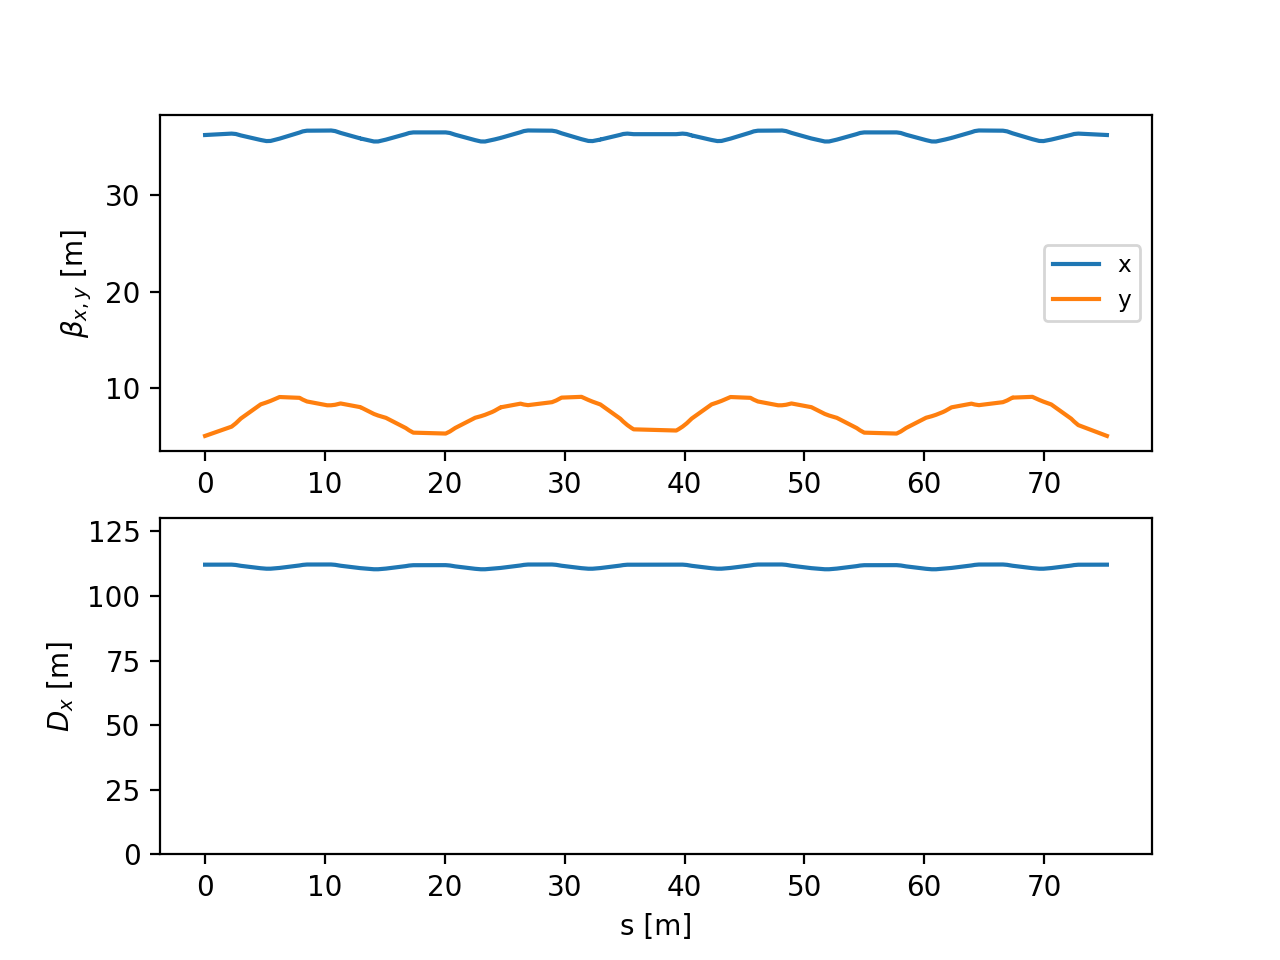

(0.0, 130.0)

In [18]:
# Optics functions
plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw0.s, tw0.betx, '-', label='x')
plt.plot(tw0.s, tw0.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw0.s, tw0.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')
plt.ylim(bottom=0, top=130)

## Control the tunes

In [19]:
opt = line.match(
    solve=False, # <- prepare the match without running it
    method='4d',
    vary=[
        xt.Vary('kqf_common', limits=(0, 1),  step=1e-3),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3),
        
    ],
    targets=[
        xt.TargetSet(qx=1.663, qy=1.72, tol=1e-6, tag='tunes'),
    ]
)


In [20]:
# Inspect situation before the match
opt.target_status()
opt.vary_status()

Target status:                          
id state tag   tol_met    residue current_val target_val description                          
 0 ON    tunes   False   -1.33475    0.328247      1.663 'qx', val=1.663, tol=1e-06, weight=10
 1 ON    tunes   False -0.0259468     1.69405       1.72 'qy', val=1.72, tol=1e-06, weight=10 
Vary status:                 
id state tag name       lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON        kqf_common           0        0.02           1          0.02 0.001      1
 1 ON        kqd                 -1       -0.02           0         -0.02 0.001      1


In [21]:
# Perform ten optimization steps
opt.step(10)

In [22]:
# Inspect optimization log
opt.log()

Table: 5 rows, 14 cols
iteration     penalty alpha tag tol_met target_active hit_limits vary_active   vary_0    vary_1 ...
        0     13.3501    -1     nn      yy            nn         yy              0.02     -0.02
        1     6.73489     1     nn      yy            nn         yy          0.437496 -0.782353
        2    0.699688     0     nn      yy            nn         yy          0.422793 -0.557715
        3    0.014287     0     nn      yy            nn         yy          0.414816 -0.527739
        4 2.10865e-06     0     yy      yy            nn         yy          0.414543 -0.527038

In [23]:
# Inspect situation after the match
opt.target_status()
opt.vary_status()

Target status:                           
id state tag   tol_met     residue current_val target_val description                          
 0 ON    tunes    True 1.85829e-08       1.663      1.663 'qx', val=1.663, tol=1e-06, weight=10
 1 ON    tunes    True 2.10045e-07        1.72       1.72 'qy', val=1.72, tol=1e-06, weight=10 
Vary status:                 
id state tag name       lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON        kqf_common           0    0.414543           1          0.02 0.001      1
 1 ON        kqd                 -1   -0.527038           0         -0.02 0.001      1


<IPython.core.display.Javascript object>


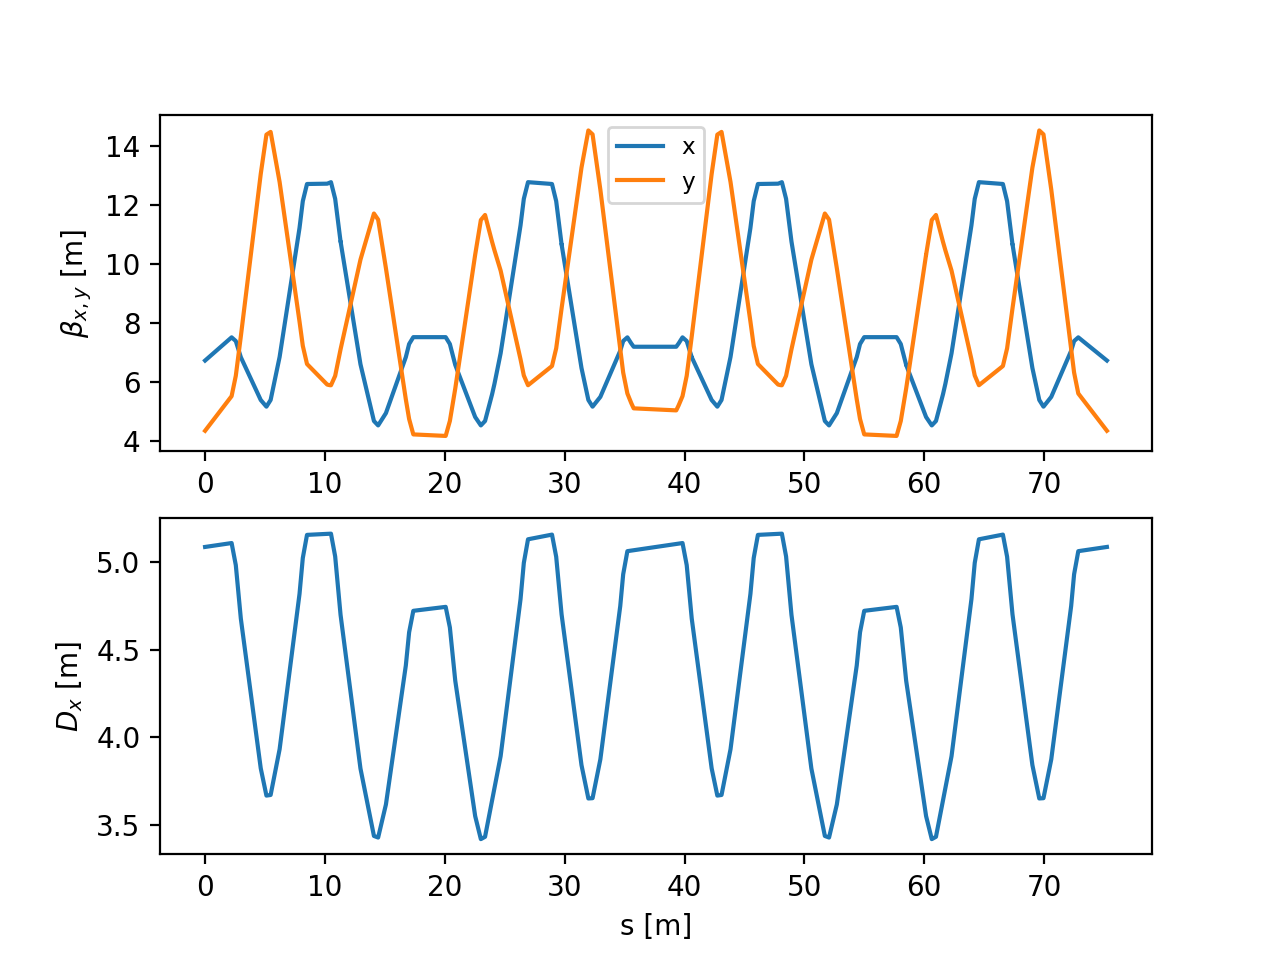

Text(0.5, 0, 's [m]')

In [24]:
# Twiss again
tw = line.twiss(method='4d')

plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw.s, tw.betx, '-', label='x')
plt.plot(tw.s, tw.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw.s, tw.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')


### Impose zero dispersion at electrostatic septum

In [29]:
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['kqfa', 'kqfb'], limits=(0, 1),  step=1e-3),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3),        
    ],
    targets=[
        xt.TargetSet(qx=1.663, qy=1.72, tol=1e-6),
        xt.Target(dx = 0, at='extr_septum', tol=1e-6)
    ]
)

In [32]:
opt.target_status()
opt.step(20)

Target status:                           
id state tag tol_met      residue current_val target_val description                                 
 0 ON           True  1.85587e-11       1.663      1.663 'qx', val=1.663, tol=1e-06, weight=10       
 1 ON           True -1.05465e-11        1.72       1.72 'qy', val=1.72, tol=1e-06, weight=10        
 2 ON           True  1.15983e-09 1.15983e-09          0 ('dx', 'extr_septum'), val=0, tol=1e-06, ...


In [33]:
opt.target_status()
opt.vary_status()

Target status:                           
id state tag tol_met      residue current_val target_val description                                 
 0 ON           True  1.85587e-11       1.663      1.663 'qx', val=1.663, tol=1e-06, weight=10       
 1 ON           True -1.05465e-11        1.72       1.72 'qy', val=1.72, tol=1e-06, weight=10        
 2 ON           True  1.15983e-09 1.15983e-09          0 ('dx', 'extr_septum'), val=0, tol=1e-06, ...
Vary status:                 
id state tag name lower_limit current_val upper_limit val_at_iter_0  step weight
 0 ON        kqfa           0    0.312041           1      0.414543 0.001      1
 1 ON        kqfb           0    0.524936           1      0.414543 0.001      1
 2 ON        kqd           -1   -0.523988           0     -0.527038 0.001      1


<IPython.core.display.Javascript object>


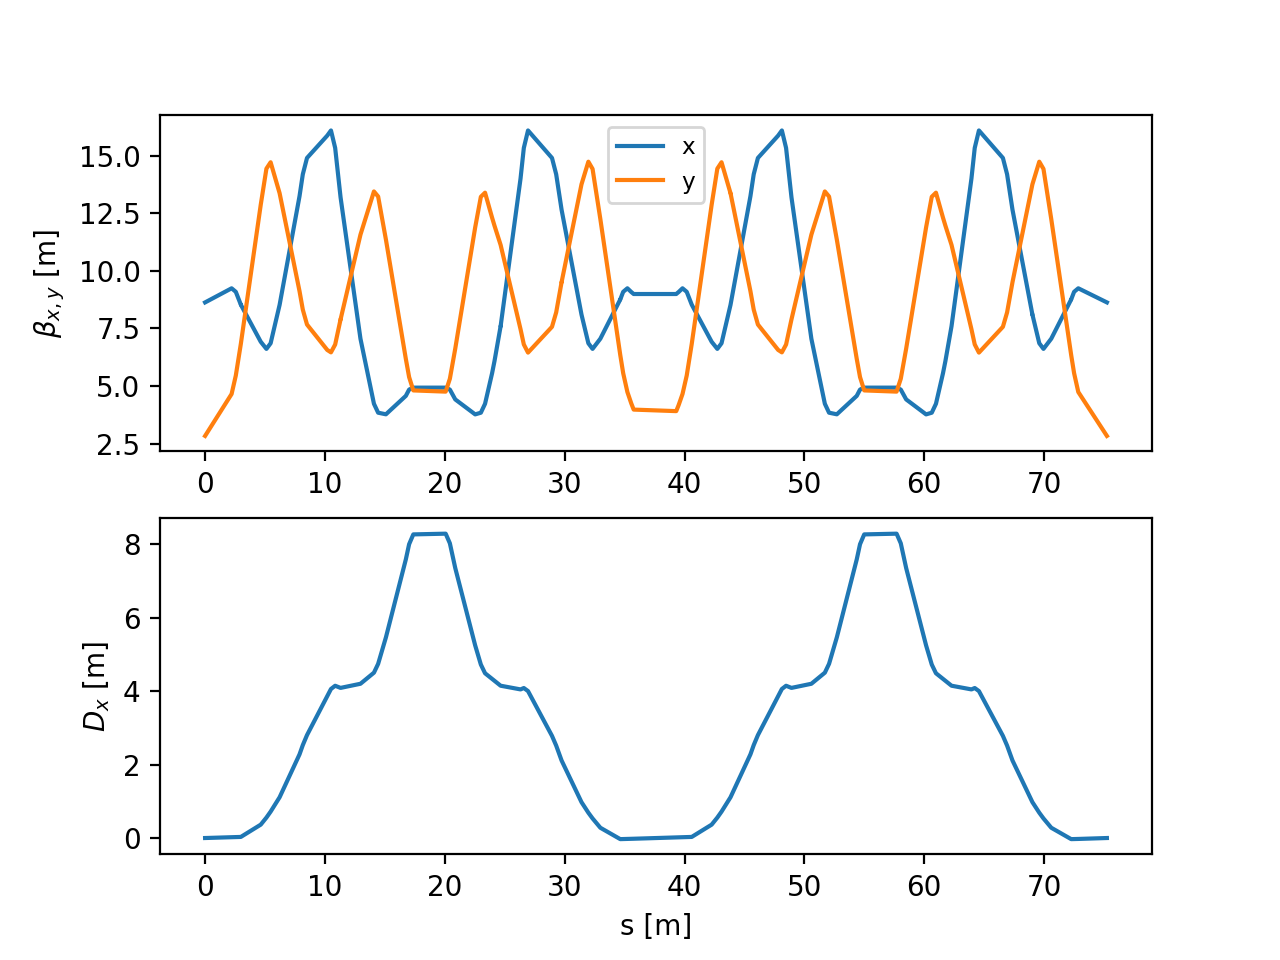

Text(0.5, 0, 's [m]')

In [34]:
# Twiss again
tw = line.twiss(method='4d')

plt.figure()
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw.s, tw.betx, '-', label='x')
plt.plot(tw.s, tw.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw.s, tw.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')

In [ ]:
opt = line.match(
    solve=False,
    method='4d',
    vary=[
        xt.VaryList(['kqf1', 'kqf2'], limits=(0, 1),  step=1e-3, tag='qf'),
        xt.Vary('kqd', limits=(-1, 0), step=1e-3, tag='qd'),
        xt.VaryList(['ksf', 'ksd'], step=1e-3),
        
    ],
    targets=[
        xt.TargetSet(qx=1.66, qy=1.72, tol=1e-6),
        xt.TargetSet(dqx=-0.1, dqy=-0.1, tol=1e-3, tag="chrom"),
        xt.Target(dx = 0, at='es_septum', tol=1e-6)
    ]
)
opt.step(20)

In [ ]:
opt.target_status()

In [ ]:
opt.vary_status()

In [ ]:
tw = line.twiss(method='4d')

plt.figure(3)
ax1 = plt.subplot(2, 1, 1)
plt.plot(tw.s, tw.betx, '-', label='x')
plt.plot(tw.s, tw.bety, '-', label='y')
plt.ylabel(r'$\beta_{x,y}$ [m]')
plt.legend(fontsize='small')

plt.subplot(2, 1, 2, sharex=ax1)
plt.plot(tw.s, tw.dx, '-', label='x')
plt.ylabel(r'$D_x$ [m]')
plt.xlabel('s [m]')

In [ ]:
line.to_json('pimms_00_optics.json')